<a href="https://colab.research.google.com/github/sujeongmoon/TimeSeriesForecastingInPython/blob/main/4_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 78p. 4.5 재현 (차분 도식화)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive//Colab Notebooks/TimeSeriesForecasstingInPython/data/widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [ ]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


In [ ]:
import numpy as np

widget_sales_diff = np.diff(df['widget_sales'], n = 1)
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


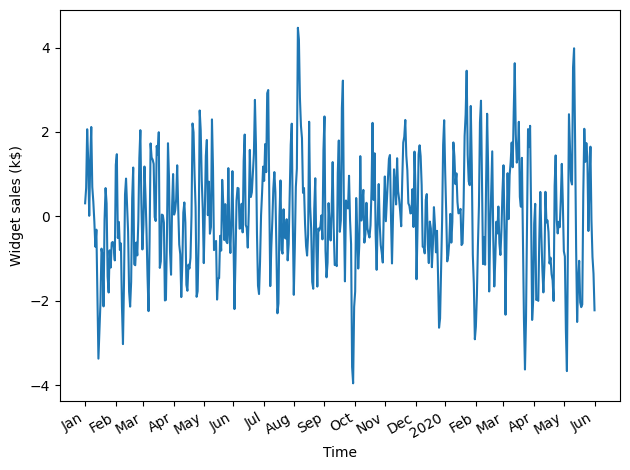

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
# ax.set_xlabel('시간')
# ax.set_ylabel('위젯 판매량 - 차분 (1천 달러)')

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

## 92p. 4.4.1 MA(2) 프로세스 시뮬레이션하고 예측 수행하기

### 1. 이번 연습에서는 1,000개의 샘플을 생성

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1,0,0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

### 2. 시뮬레이션한 이동평균 도식화

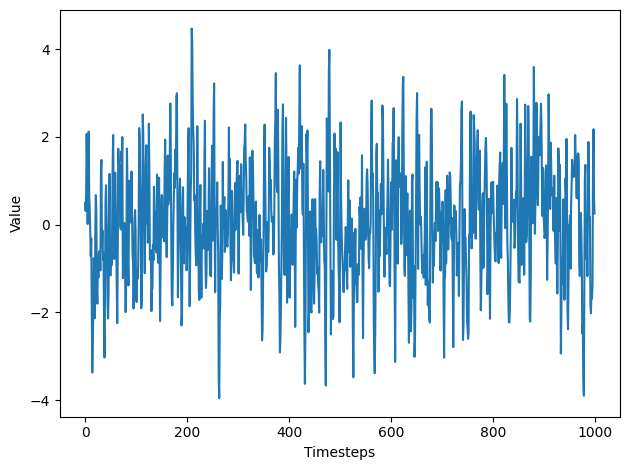

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

### 3. ADF 테스트를 실행하고 프로세스가 정상적인지 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.005444309194495
p-value: 3.7956016167135026e-26


### 4. ACF를 도식화하고 지연 2 이후에 유의한 계수가 있는지 확인

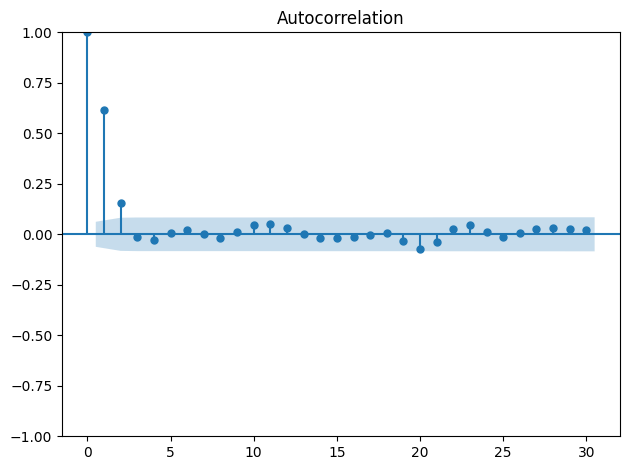

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(MA2_process, lags = 30)

plt.tight_layout()

### 5. 시뮬레이션된 수열을 훈련 집합과 테스트 집합으로 분할 (800/200)

In [ ]:
train = MA2_process[:int(0.8*len(MA2_process))]
test = MA2_process[int(0.8*len(MA2_process)):]
print(len(train))
print(len(test))


800
200


### 6. 테스트 집합에 대해 예측 수행

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def recursive_forecast(df:np.ndarray, train_len: int, horizon: int,
                       window: int, method: str ) -> list:

  total_len = train_len + horizon

  # 평균값
  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  # 마지막 값
  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[i-1]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  # MA(2)
  elif method == 'MA':
    pred_MA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(0,0,2))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean[-window:]
      pred_MA.extend(oos_pred)

    return pred_MA

In [ ]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = recursive_forecast(MA2_process, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = recursive_forecast(MA2_process, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = recursive_forecast(MA2_process, TRAIN_LEN, HORIZON, WINDOW, 'MA')



### 7. 예측값 도식화

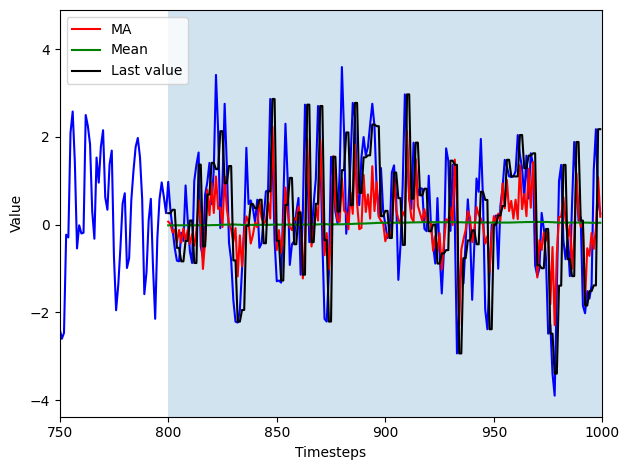

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(MA2_process, 'b-')
ax.plot(range(800,1000), pred_MA, 'r-', label='MA')
ax.plot(range(800,1000), pred_mean, 'g-', label='Mean')
ax.plot(range(800,1000), pred_last, 'k-', label='Last value')

ax.axvspan(len(train), len(train) + len(test), alpha=0.2)
ax.legend(loc = 2)

plt.xlim(750, 1000)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')


plt.tight_layout()

## 8. MSE 측정 및 챔피언 모델 식별

In [ ]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test, pred_mean)
mse_last = mean_squared_error(test, pred_last)
mse_MA = mean_squared_error(test, pred_MA)

print(mse_mean, mse_last, mse_MA)

1.8635013982365882 1.988201688527919 1.2323542190589272


## 9. 막대형 도식으로 MSE 도식화

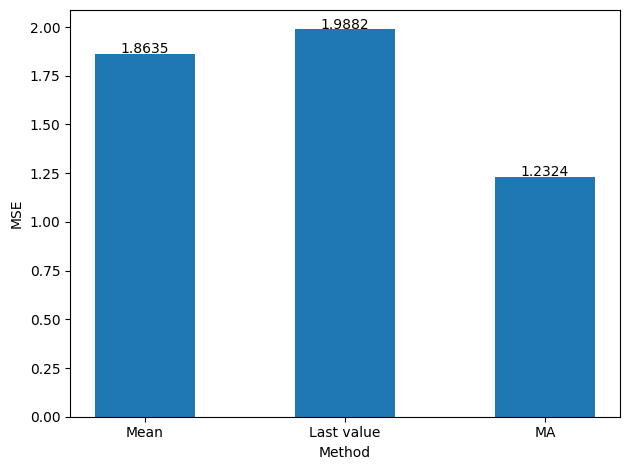

In [ ]:
fig, ax = plt.subplots()

x = ['Mean', 'Last value', 'MA']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width = 0.5)
ax.set_xlabel('Method')
ax.set_ylabel('MSE')

for index, value in enumerate(y):
  plt.text(x = index, y = value + 0.001, s = str(round(value, 4)), ha = 'center')

plt.tight_layout()